# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git
!pip install -q wandb
!pip install -q torchmetrics
!pip install torchinfo

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 37 (delta 35), pack-reused 6293 (from 1)
Receiving objects: 100% (6559/6559), 116.26 MiB | 16.71 MiB/s, done.
Resolving deltas: 100% (275/275), done.
Updating files: 100% (5717/5717), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 21.6 MB/s eta 0:00:00


## Import dependencies

In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple
from torchvision import transforms as T
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from torch.optim import AdamW, SGD
from tqdm.notebook import tqdm
from torchmetrics.classification.accuracy import Accuracy
from torch.optim.lr_scheduler import OneCycleLR
from shutil import copy
import wandb
import torch.nn.functional as F
from torchsummary import summary
from torchvision.models import resnet18, ResNet18_Weights
from typing import Optional
import random
import numpy as np
from typing import Dict, Any
import matplotlib.pyplot as plt
from collections import Counter
import os
from torchinfo import summary
import pandas as pd
import seaborn as sn

## Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# wandb
WANDB_PROJECT = "IPCV_ASS2"
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Util functions

In [6]:
import matplotlib.pyplot as plt

def show_sample_images(dataloader, grid_size=4):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    num_images = grid_size * grid_size

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 3, grid_size * 3))
    axes = axes.flatten()

    for i in range(num_images):
        axes[i].imshow(images[i].permute(1, 2, 0))
        axes[i].set_title(f'Class: {labels[i].item()}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_class_distribution(dataset):
    all_labels = [label for _, label in dataset]
    label_counts = Counter(all_labels)

    classes = list(label_counts.keys())
    counts = list(label_counts.values())

    sorted_classes, sorted_counts = zip(*sorted(zip(classes, counts), key=lambda x: x[1], reverse=True))

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_classes, sorted_counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title('Class distribution')
    plt.show()

def save_model_to_drive(run_name, model):
    path = f"/content/drive/MyDrive/IPCV-ASS2/{run_name}"
    os.makedirs(os.path.dirname(path), exist_ok=True)

    torch.save(model.state_dict(), path)
    print(f'Model saved to {path} as {run_name}')

def load_model_from_drive(run_name, model):
    path = f"/content/drive/MyDrive/IPCV-ASS2/{run_name}"
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint)

def get_pretrained_model(
        num_classes: int,
        weights: Optional[ResNet18_Weights] = None
    ) -> nn.Module:
    """Gets an image classifier based on ResNet-18.

    Args:
        num_classes: the number of classes.
        weights: pretrained weights to load into the network.
                 If None, the network is randomly initialized.

    Returns:
        The required network.
    """
    model = resnet18(weights=weights)
    # Here we override the old classifier
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

def set_requires_grad(layer: torch.nn.Module, train: bool) -> None:
    """Sets the requires_grad attribute to True or False for each parameter within a layer.

        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

def print_summary(net, input_size, verbose=True):
    from torchinfo import summary
    net_info = summary(net, input_size=input_size)
    params = net_info.total_params
    macs = net_info.total_mult_adds
    if verbose: print(net_info)
    print("\nNetwork's n°params: %.3fk \tMAC: %.3fM\n" % (params/1e3, macs/1e6))

## Reproducibility

In [7]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=42)

## Dataset, DataLoader

In [8]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [9]:
train_dataset = GroceryStoreDataset(split='train')
val_dataset = GroceryStoreDataset(split='val')

print("Original sizes before transform: ")
print(f"Size of images in training dataset:" + str(set(img.size for img, _ in train_dataset)))
print(f"Size of images in validation dataset:" + str(set(img.size for img, _ in val_dataset)))

data_transforms = {
    "train":  T.Compose([
              T.ToTensor(),
              T.Resize((348, 348)),
              ]),

    "val":  T.Compose([
            T.ToTensor(),
            T.Resize((348, 348)),
            ])
}

augmentation = T.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomRotation((-7,7)),
    v2.RandomPerspective(distortion_scale=0.5, p=0.2),
    v2.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Resize((348, 348)),
])

# Dataset for ablation study without data augmentation
train_dataset_ablation_study = GroceryStoreDataset(split='train', transform=data_transforms['train'])
val_dataset = GroceryStoreDataset(split='val', transform=data_transforms['val'])

train_loader_ablation_study = DataLoader(train_dataset_ablation_study, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Dataset with augmented data
train_dataset_augmented = GroceryStoreDataset(split='train', transform=augmentation)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)

Original sizes before transform: 
Size of images in training dataset:{(348, 464), (464, 348), (348, 348)}
Size of images in validation dataset:{(348, 348)}


In [10]:
print("Sizes after transform: ")

print(f"Size of images in training dataset:" + str(set(img.size() for img, _ in train_dataset_ablation_study)))
print(f"Size of images in validation dataset:" + str(set(img.size() for img, _ in val_dataset)))

Sizes after transform: 
Size of images in training dataset:{torch.Size([3, 348, 348])}
Size of images in validation dataset:{torch.Size([3, 348, 348])}


## Data exploration and distribution

In [11]:

print(f"Number of classes: {train_dataset.get_num_classes()}")

Number of classes: 43


Examples images

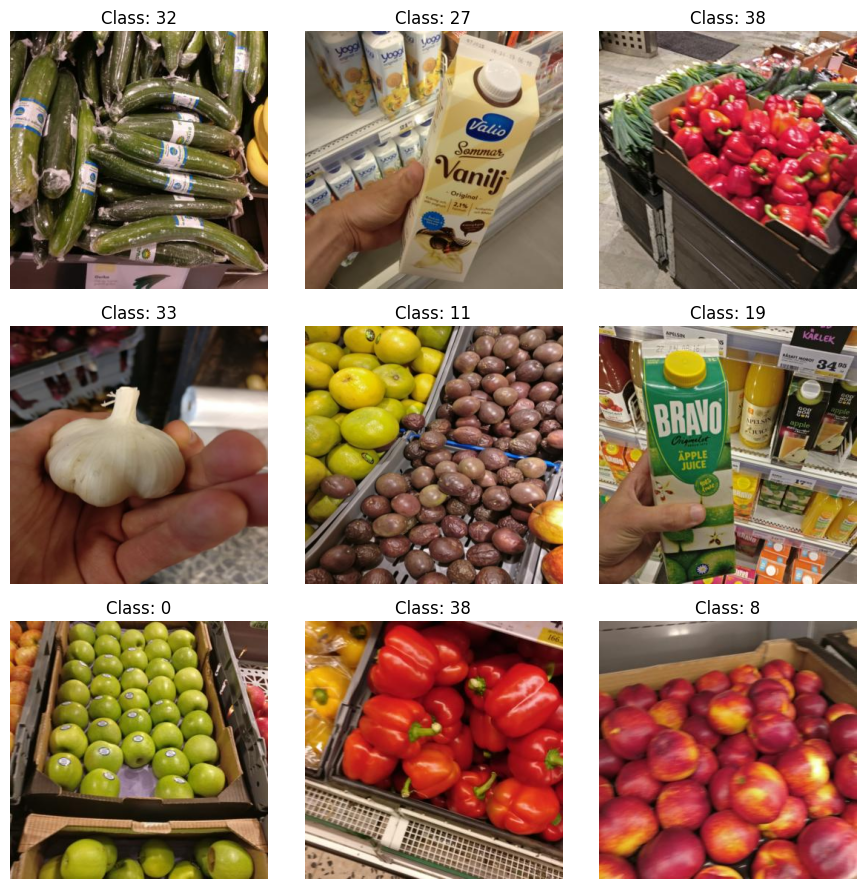

In [12]:
show_sample_images(train_loader_ablation_study, 3)

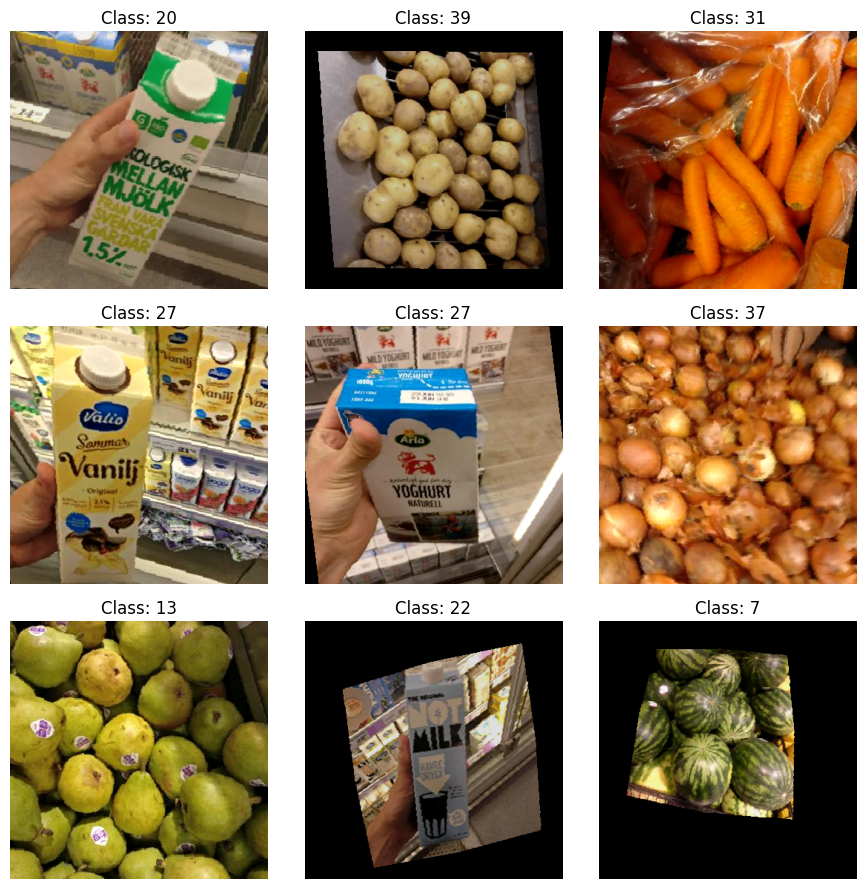

In [13]:
show_sample_images(train_loader_augmented, 3)

Visualize class distribution on TRAIN

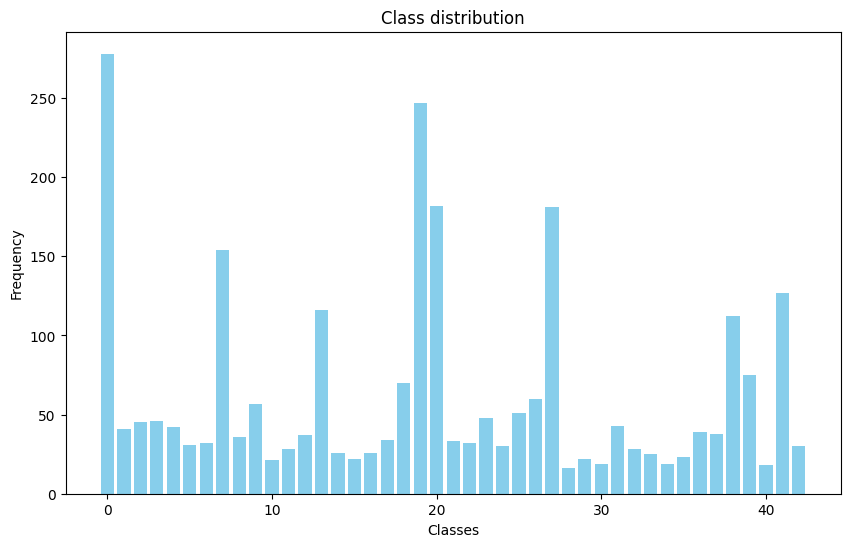

In [14]:
plot_class_distribution(train_dataset)

Visualize class distribution on VALIDATION

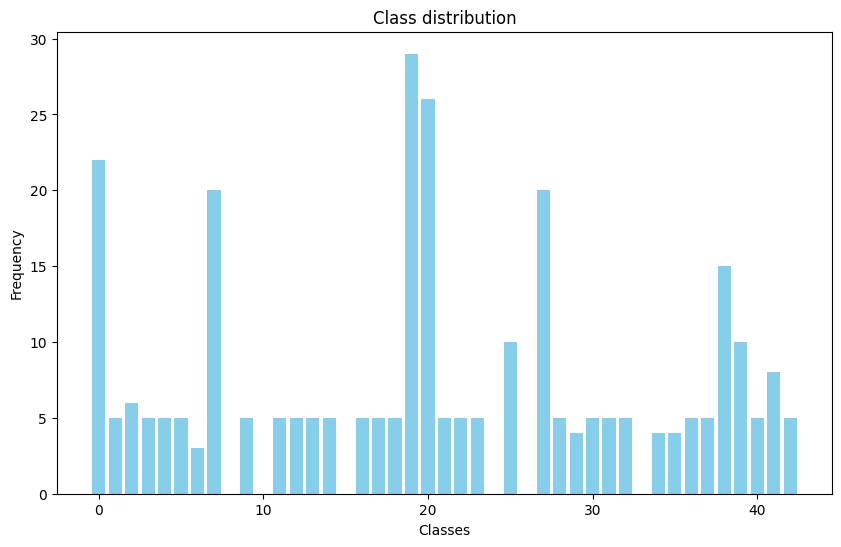

In [15]:
plot_class_distribution(val_dataset)

The dataset as you can see is not well balanced and this will not help in learning to recognize the classes less covered

## TrainingLoop, Validation

## General specifications

In [16]:
num_classes = train_dataset.get_num_classes()

# Dict of dataset classes
class_dict = [
    "Apple",
    "Avocado",
    "Banana",
    "Kiwi",
    "Lemon",
    "Lime",
    "Mango",
    "Melon",
    "Nectarine",
    "Orange",
    "Papaya",
    "Passion-Fruit",
    "Peach",
    "Pear",
    "Pineapple",
    "Plum",
    "Pomegranate",
    "Red-Grapefruit",
    "Satsumas",
    "Juice",
    "Milk",
    "Oatghurt",
    "Oat-Milk",
    "Sour-Cream",
    "Sour-Milk",
    "Soyghurt",
    "Soy-Milk",
    "Yoghurt",
    "Asparagus",
    "Aubergine",
    "Cabbage",
    "Carrots",
    "Cucumber",
    "Garlic",
    "Ginger",
    "Leek",
    "Mushroom",
    "Onion",
    "Pepper",
    "Potato",
    "Red-Beet",
    "Tomato",
    "Zucchini",
]

In [17]:
class Trainer:
    def __init__(self,
            model: nn.Module,
            train_loader: DataLoader,
            val_loader: DataLoader,
            device: torch.device,
            num_classes: int
        ) -> None:
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.num_epochs = cfg["num_epochs"]

        self.model = model.to(device)
        self.optimizer = AdamW(self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
        num_steps = self.num_epochs * len(train_loader)
        self.scheduler = OneCycleLR(self.optimizer, cfg["lr"], total_steps=num_steps)

        self.step = 0
        self.best_acc = 0.0

        wandb.init(name=cfg["run_name"], project=WANDB_PROJECT, config=cfg)
        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

    def logfn(self, values: Dict[str, Any]) -> None:
        wandb.log(values, step=self.step, commit=False)

    def train(self) -> None:
        for _ in tqdm(range(self.num_epochs), desc="Epoch", colour="green"):
            self.model.train()

            for imgs, labels in self.train_loader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                pred = self.model(imgs)
                loss = F.cross_entropy(pred, labels, label_smoothing=cfg["ls"])

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                if self.step % 10 == 0:
                    self.logfn({"train/loss": loss.item()})
                    self.logfn({"train/lr": self.scheduler.get_last_lr()[0]})

                self.step += 1

            self.eval("train")
            self.eval("val")

        wandb.finish()

    @torch.no_grad()
    def eval(self, split: str) -> None:
        self.model.eval()

        loader = self.train_loader if split == "train" else self.val_loader
        confusion_matrix = torch.zeros(self.num_classes, self.num_classes, dtype=torch.int)

        losses = []
        for imgs, labels in loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            scores = self.model(imgs)
            loss = F.cross_entropy(scores, labels)
            losses.append(loss.item())

            preds = torch.argmax(scores, dim=-1)
            for lbl, pred in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[lbl.long(), pred.long()] += 1

        mean_loss = sum(losses) / len(losses)
        accuracy = (torch.diagonal(confusion_matrix).sum() / confusion_matrix.sum()).item()

        self.logfn({f"{split}/loss": mean_loss})
        self.logfn({f"{split}/acc": accuracy})

        if split == "val":
            conf_mtrx_df = pd.DataFrame(confusion_matrix)
            plt.figure(figsize=(18, 15))
            heatmap = sn.heatmap(conf_mtrx_df,
                annot=True,
                fmt="d",
                xticklabels=class_dict,
                yticklabels=class_dict)
            plt.title(f"{split.capitalize()} Confusion Matrix")
            plt.xticks(rotation=90)
            self.logfn({f"{split}/confusion_matrix": wandb.Image(heatmap.get_figure())})
            plt.close()

        if accuracy > self.best_acc and split == "val":
            self.best_acc = accuracy
            save_model_to_drive(f"{wandb.run.name}.pt", self.model)

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In [18]:
cfg = {
    "run_name": "",
    "resize_size": 384,
    "batch_size": 64,
    "num_epochs": 100,
    "ls": 0.1,
    "lr": 1e-3,
    "wd": 0.01,
}

In [19]:
class TinyShuffleNet(nn.Module):
    def __init__(self, in_channels, groups, num_classes):
        super(TinyShuffleNet, self).__init__()

        self.groups = groups

        self.conv1 = nn.Conv2d(3, in_channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.stage2 = self._make_stage(in_channels, in_channels * 2, num_blocks=2, stride=2)
        self.stage3 = self._make_stage(in_channels * 2, in_channels * 4, num_blocks=2, stride=2)
        self.stage4 = self._make_stage(in_channels * 4, in_channels * 8, num_blocks=2, stride=2)

        self.globalpool = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(0.5)
        self.fc = nn.Linear(in_channels * 8, num_classes)

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        for i in range(num_blocks):
            stride_layer = stride if i == 0 else 1
            layers.append(ShuffleUnit(in_channels, out_channels, stride=stride_layer, groups=self.groups))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.globalpool(x)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        x = self.fc(x)

        return x


class ShuffleUnit(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, groups=2):
        super(ShuffleUnit, self).__init__()
        self.stride = stride
        self.groups = groups

        self.out_channels = out_channels
        mid_channels = out_channels // 4

        # 1x1 GConv
        self.group_conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, groups=groups, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        # 3x3 DWConv
        self.depthwise_conv = nn.Conv2d(mid_channels, mid_channels, kernel_size=3,
                                      stride=stride, padding=1, groups=mid_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)

        # 1x1 GConv
        self.group_conv2 = nn.Conv2d(mid_channels, out_channels if stride == 1 else out_channels - in_channels,
                                   kernel_size=1, groups=groups, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels if stride == 1 else out_channels - in_channels)

        # Shortcut
        if stride == 2:
            self.shortcut = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        else:
            self.shortcut = nn.Identity()

    def channel_shuffle(self, x):
      batchsize, num_channels, height, width = x.size()
      channels_per_group = num_channels // self.groups
      x = x.view(batchsize, self.groups, channels_per_group, height, width)
      x = torch.transpose(x, 1, 2).contiguous()
      x = x.view(batchsize, -1, height, width)
      return x

    def forward(self, x):
        residual = self.shortcut(x)

        x = F.relu(self.bn1(self.group_conv1(x)))

        if self.groups > 1:
          x = self.channel_shuffle(x)

        x = self.bn2(self.depthwise_conv(x))
        x = self.bn3(self.group_conv2(x))

        if self.stride == 2:
            x = torch.cat([x, residual], 1)
        else:
            x = x + residual

        return F.relu(x)

In [20]:
model = TinyShuffleNet(96, 3, num_classes)
print_summary(model, (64, 3, 384, 384))

cfg["run_name"] = "SHUFFLE_96C3G_DROPOUT_LS"

trainer = Trainer(
    model,
    train_loader_augmented,
    val_loader,
    device,
    num_classes
)

trainer.train()

wandb: Currently logged in as: baronc. Use `wandb login --relogin` to force relogin


Layer (type:depth-idx)                   Output Shape              Param #
TinyShuffleNet                           [64, 43]                  --
├─Conv2d: 1-1                            [64, 96, 192, 192]        2,592
├─BatchNorm2d: 1-2                       [64, 96, 192, 192]        192
├─MaxPool2d: 1-3                         [64, 96, 96, 96]          --
├─Sequential: 1-4                        [64, 192, 48, 48]         --
│    └─ShuffleUnit: 2-1                  [64, 192, 48, 48]         --
│    │    └─AvgPool2d: 3-1               [64, 96, 48, 48]          --
│    │    └─Conv2d: 3-2                  [64, 48, 96, 96]          1,536
│    │    └─BatchNorm2d: 3-3             [64, 48, 96, 96]          96
│    │    └─Conv2d: 3-4                  [64, 48, 48, 48]          432
│    │    └─BatchNorm2d: 3-5             [64, 48, 48, 48]          96
│    │    └─Conv2d: 3-6                  [64, 96, 48, 48]          1,536
│    │    └─BatchNorm2d: 3-7             [64, 96, 48, 48]          192
│  

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/IPCV-ASS2/SHUFFLE_96C3G_DROPOUT_LS.pt as SHUFFLE_96C3G_DROPOUT_LS.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/SHUFFLE_96C3G_DROPOUT_LS.pt as SHUFFLE_96C3G_DROPOUT_LS.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/SHUFFLE_96C3G_DROPOUT_LS.pt as SHUFFLE_96C3G_DROPOUT_LS.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/SHUFFLE_96C3G_DROPOUT_LS.pt as SHUFFLE_96C3G_DROPOUT_LS.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/SHUFFLE_96C3G_DROPOUT_LS.pt as SHUFFLE_96C3G_DROPOUT_LS.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/SHUFFLE_96C3G_DROPOUT_LS.pt as SHUFFLE_96C3G_DROPOUT_LS.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/SHUFFLE_96C3G_DROPOUT_LS.pt as SHUFFLE_96C3G_DROPOUT_LS.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/SHUFFLE_96C3G_DROPOUT_LS.pt as SHUFFLE_96C3G_DROPOUT_LS.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/SHUFFLE_96C3G_DROPOUT_LS.pt as SHUFFLE_96C3G_DROPOUT_LS.pt
Model saved to /content/drive/MyDrive

train/acc,▁▁▃▃▃▅▄▆▅▅▆▆▆▅▆▇▇▇▇█████████████████████
train/loss,█▆▇▅▅▅▆▅▅▅▅▄▄▄▄▄▄▃▂▃▃▃▃▃▃▃▃▃▁▃▃▃▃▃▃▃▃▃▁▃
train/lr,▁▁▁▁▂▃▃▃▃▄▅▅▆▆▇███████▇▇▇▆▅▅▅▅▃▃▂▂▂▁▁▁▁▁
val/acc,▁▂▂▃▃▅▄▆▆▅▆▆▄▆▇▇▅▇▆█▇▇▇▇▇▇██▇▇██████████
val/loss,█▅▄▃▃▃▃▅▄▂▃▄▃▄▂▁▂▁▂▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
train/acc,0.99886
train/loss,0.09793
train/lr,0.0
val/acc,0.69595
val/loss,1.16101


In [21]:
model = TinyShuffleNet(96, 3, num_classes)
print_summary(model, (64, 3, 384, 384))

cfg["run_name"] = "ABLATION_NO_AUGMENTED"

trainer = Trainer(
    model,
    train_loader_ablation_study,
    val_loader,
    device,
    num_classes
)

trainer.train()

Layer (type:depth-idx)                   Output Shape              Param #
TinyShuffleNet                           [64, 43]                  --
├─Conv2d: 1-1                            [64, 96, 192, 192]        2,592
├─BatchNorm2d: 1-2                       [64, 96, 192, 192]        192
├─MaxPool2d: 1-3                         [64, 96, 96, 96]          --
├─Sequential: 1-4                        [64, 192, 48, 48]         --
│    └─ShuffleUnit: 2-1                  [64, 192, 48, 48]         --
│    │    └─AvgPool2d: 3-1               [64, 96, 48, 48]          --
│    │    └─Conv2d: 3-2                  [64, 48, 96, 96]          1,536
│    │    └─BatchNorm2d: 3-3             [64, 48, 96, 96]          96
│    │    └─Conv2d: 3-4                  [64, 48, 48, 48]          432
│    │    └─BatchNorm2d: 3-5             [64, 48, 48, 48]          96
│    │    └─Conv2d: 3-6                  [64, 96, 48, 48]          1,536
│    │    └─BatchNorm2d: 3-7             [64, 96, 48, 48]          192
│  

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/IPCV-ASS2/ABLATION_NO_AUGMENTED.pt as ABLATION_NO_AUGMENTED.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/ABLATION_NO_AUGMENTED.pt as ABLATION_NO_AUGMENTED.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/ABLATION_NO_AUGMENTED.pt as ABLATION_NO_AUGMENTED.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/ABLATION_NO_AUGMENTED.pt as ABLATION_NO_AUGMENTED.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/ABLATION_NO_AUGMENTED.pt as ABLATION_NO_AUGMENTED.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/ABLATION_NO_AUGMENTED.pt as ABLATION_NO_AUGMENTED.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/ABLATION_NO_AUGMENTED.pt as ABLATION_NO_AUGMENTED.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/ABLATION_NO_AUGMENTED.pt as ABLATION_NO_AUGMENTED.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/ABLATION_NO_AUGMENTED.pt as ABLATION_NO_AUGMENTED.pt
Model saved to /content/drive/MyDrive/IPCV-ASS2/ABLATION_NO_AUGMENTED.pt as ABLATION_NO_AUG

train/acc,▁▃▃▃▅▇▇▇▇▇▇█████████████████████████████
train/loss,██▇▇▆▃▄▃▄▄▃▃▁▃▃▃▃▁▃▃▃▁▃▃▃▃▁▃▃▃▃▁▃▃▃▃▃▃▃▃
train/lr,▁▁▂▂▂▃▄▄▆▆▇████████▇▇▇▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val/acc,▁▂▃▄▅▆▆▇▆▆▆▇▇▇▇▇██▇▇▇██▇████████████████
val/loss,█▇▅▃▃▂▃▂▃▂▃▂▁▂▂▃▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
train/acc,1
train/loss,0.06146
train/lr,0.0
val/acc,0.65541
val/loss,1.55622


## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
resnet18 = resnet18(weights=weights)

def set_requires_grad(layer: torch.nn.Module, train: bool) -> None:
    """Sets the requires_grad attribute to True or False for each parameter within a layer.

        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

set_requires_grad(resnet18.conv1, False)
set_requires_grad(resnet18.bn1, False)
set_requires_grad(resnet18.layer1, False)
set_requires_grad(resnet18.layer2, False)
set_requires_grad(resnet18.layer3, False)
set_requires_grad(resnet18.layer4, False)

resnet18.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet18.fc.in_features, train_dataset.get_num_classes()),
)

print_summary(
    resnet18,
    input_size=(64, 3, cfg["resize_size"], cfg["resize_size"])
)

cfg["run_name"] = "resnet18_finetune"
cfg["num_epochs"] = 10

resnet18_trainer = Trainer(
    resnet18,
    train_loader_augmented,
    val_loader,
    device,
    train_dataset.get_num_classes()
)

resnet18_trainer.train()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 43]                  --
├─Conv2d: 1-1                            [64, 64, 192, 192]        (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 192, 192]        (128)
├─ReLU: 1-3                              [64, 64, 192, 192]        --
├─MaxPool2d: 1-4                         [64, 64, 96, 96]          --
├─Sequential: 1-5                        [64, 64, 96, 96]          --
│    └─BasicBlock: 2-1                   [64, 64, 96, 96]          --
│    │    └─Conv2d: 3-1                  [64, 64, 96, 96]          (36,864)
│    │    └─BatchNorm2d: 3-2             [64, 64, 96, 96]          (128)
│    │    └─ReLU: 3-3                    [64, 64, 96, 96]          --
│    │    └─Conv2d: 3-4                  [64, 64, 96, 96]          (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 96, 96]          (128)
│    │    └─ReLU: 3-6                    [64, 64, 96, 96]  

train/acc,▁
train/loss,█▆▄▃▁▁
train/lr,▁▂▃▅█
val/acc,▁
val/loss,▁
train/acc,0.11553
train/loss,3.50095
train/lr,4e-05
val/acc,0.07432
val/loss,3.54695


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
set_requires_grad(resnet18.conv1, True)
set_requires_grad(resnet18.bn1, True)
set_requires_grad(resnet18.layer1, True)
set_requires_grad(resnet18.layer2, True)
set_requires_grad(resnet18.layer3, True)
set_requires_grad(resnet18.layer4, True)

cfg["num_epochs"] = 10
cfg["lr"] = 1e-4

resnet18_trainer = Trainer(
    resnet18,
    train_loader_augmented,
    val_loader,
    device,
    train_dataset.get_num_classes()
)

resnet18_trainer.train()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 